## Feed Forward Neural Network in Fake Data


### Importing Libraries

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive 
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Loading dataset

In [3]:
#read a '.csv' file into data-frame
df = pd.read_csv('gdrive/My Drive/text_pre_processing.csv', sep=',')

df.sample(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
32866,32866,32872,China hopes all sides' words and actions reduc...,BEIJING (Reuters) - China said on Monday that ...,worldnews,2017-11-06,True,2,"['BEIJING', '(Reuters)', 'China', 'said', 'on'...",[],BEIJING - china said on monday that it hopes...,[],[],china hopes all sides' words and actions reduc...,"['BEIJING', 'china', 'said', 'on', 'that', 'it...","['china', 'hopes', 'all', 'sides', 'words', 'a..."
6128,6128,6128,"Trump Didn’t Want These Secrets To Get Out, B...",Donald Trump has been trying to suppress inter...,News,2016-05-28,fake,14,"['Donald', 'Trump', 'has', 'been', 'trying', '...",[],donald trump has been trying to suppress inter...,[],[],"trump didn’t want these secrets to get out, bu...","['donald', 'trump', 'has', 'been', 'trying', '...","['trump', 'didn', 'want', 'these', 'secrets', ..."
11724,11724,11725,WATCH HILARIOUSLY AWKWARD Moment Between Rick ...,Franken asked Perry if he enjoyed a meeting th...,politics,2017-01-20,fake,33,"['Franken', 'asked', 'Perry', 'if', 'he', 'enj...",['https://www.youtube.com/watch?v=gxrKlVv4UDA'],franken asked perry if he enjoyed a meeting th...,[],[],WATCH HILARIOUSLY AWKWARD moment between rick ...,"['franken', 'asked', 'perry', 'if', 'he', 'enj...","['WATCH', 'HILARIOUSLY', 'AWKWARD', 'moment', ..."
27166,27166,27172,Email privacy bill unanimously passes U.S. House,WASHINGTON (Reuters) - The U.S. House of Repre...,politicsNews,2016-04-27,true,4,"['WASHINGTON', '(Reuters)', 'The', 'U', 'S', '...",[],WASHINGTON - the U.S. house of representativ...,[],[],email privacy bill unanimously passes U.S. house,"['WASHINGTON', 'the', 'U.S.', 'house', 'of', '...","['email', 'privacy', 'bill', 'unanimously', 'p..."
1331,1331,1331,College Graduates Keep Rejecting Trump’s Evil...,Graduates of University of Notre Dame s 2017 c...,News,2017-05-30,fake,13,"['Graduates', 'of', 'University', 'of', 'Notre...",[],graduates of university of notre dame s clas...,[],[],college graduates keep rejecting trump’s evil ...,"['graduates', 'of', 'university', 'of', 'notre...","['college', 'graduates', 'keep', 'rejecting', ..."


In [4]:
#drop the duplicated and unwanted columns
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.sample(5)

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
32791,March in Poland mourns man who set himself on ...,WARSAW (Reuters) - Several hundred people walk...,worldnews,2017-11-06,True,2,"['WARSAW', '(Reuters)', 'Several', 'hundred', ...",[],WARSAW - several hundred people walked in si...,[],[],march in poland mourns man who set himself on ...,"['WARSAW', 'several', 'hundred', 'people', 'wa...","['in', 'poland', 'mourns', 'man', 'who', 'set'..."
233,FEMA: It’s ‘Not Our Job’ To Deliver Food And ...,"If you re sitting at your computer, take a dee...",News,2017-10-11,fake,17,"['If', 'you', 're', 'sitting', 'at', 'your', '...",[],"if you re sitting at your computer, take a dee...",[],[],FEMA: it’s ‘not our job’ to deliver food and w...,"['if', 'you', 're', 'sitting', 'at', 'your', '...","['FEMA', 'it', 'not', 'our', 'job', 'to', 'del..."
33108,"Turkish troops, Kurdish militants clash near I...","DIYARBAKIR, Turkey (Reuters) - Turkish securit...",worldnews,2017-11-02,True,3,"['DIYARBAKIR', 'Turkey', '(Reuters)', 'Turkish...",[],"DIYARBAKIR, turkey - turkish security forces...",[],[],"turkish troops, kurdish militants clash near i...","['DIYARBAKIR', 'turkey', 'turkish', 'security'...","['turkish', 'troops', 'kurdish', 'militants', ..."
31829,Britain's government to push ahead with plan o...,LONDON (Reuters) - Britain s Prime Minister Th...,worldnews,2017-11-17,true,2,"['LONDON', '(Reuters)', 'Britain', 's', 'Prime...",[],LONDON - britain s prime minister theresa ma...,[],[],britain's government to push ahead with plan o...,"['LONDON', 'britain', 'prime', 'minister', 'th...","['britain', 'government', 'to', 'push', 'ahead..."
30428,Israeli missiles target Syrian military facili...,BEIRUT (Reuters) - Syrian state media on Monda...,worldnews,2017-12-04,true,4,"['BEIRUT', '(Reuters)', 'Syrian', 'state', 'me...",[],BEIRUT - syrian state media on monday said i...,[],[],israeli missiles target syrian military facili...,"['BEIRUT', 'syrian', 'state', 'media', 'on', '...","['israeli', 'missiles', 'target', 'syrian', 'm..."


In [5]:
#show some basic description 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
caps_in_title,38638.0,13.545059,14.541594,1.0,3.0,6.0,20.0,137.0


In [ ]:
#and other extra info for this dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38638 entries, 0 to 38637
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               38638 non-null  object
 1   text                38638 non-null  object
 2   subject             38638 non-null  object
 3   date                38638 non-null  object
 4   label               38638 non-null  object
 5   caps_in_title       38638 non-null  int64 
 6   text_tokens         38638 non-null  object
 7   text_urls           38638 non-null  object
 8   clean_text          38638 non-null  object
 9   title_urls          38638 non-null  object
 10  twitter_handles     38638 non-null  object
 11  clean_title         38638 non-null  object
 12  clean_text_tokens   38638 non-null  object
 13  clean_title_tokens  38638 non-null  object
dtypes: int64(1), object(13)
memory usage: 4.1+ MB


### Splitting Dataset Procedure

---
We split the data in 3 smaller datasets:
* Training, validation and test datasets



In [6]:
#the column 'clean_text' is the one we want to split
X = df['clean_text'].reset_index(drop=True)

X.sample(10)

38195    ANKARA   - turkey said it will start the first...
31923    ANKARA   - iran rejected as wrong some british...
13747    watch this video and you ll see why this man i...
34073    MADRID   - the people of catalonia cannot acce...
19398    WASHINGTON   - democratic state officials blas...
9135     the former fox news contributor and editor of ...
37922    MADRID   - the spanish constitutional court ha...
14934    there s something about these sassy ladies tha...
7158     for months concerns have been expressed about ...
7671     add comedian louis C.K. to the ever-growing lo...
Name: clean_text, dtype: object

In [7]:
y = df['label'].to_frame()

y.sample(10)

,label
12155,fake
14365,fake
1124,fake
17083,fake
37670,True
25717,true
7068,fake
29675,true
13061,fake
4396,fake


In [8]:
y[y['label'] == True] = 'true'
y = y.squeeze() #convert the data-frame to array
y

0        fake
1        fake
2        fake
3        fake
4        fake
         ... 
38633    true
38634    true
38635    true
38636    true
38637    true
Name: label, Length: 38638, dtype: object

In [9]:
#how the labels are distributed
y.value_counts(normalize=True)

true    0.54845
fake    0.45155
Name: label, dtype: float64

---
At first, we will split the main dataset into two parts:
* Train-Validation dataset and
* Test dataset (25% of the whole dataset)

After that, we will split the Train-Validation dataset into another two:
* Train dataset and
* Validation dataset (15% of the train-validation dataset)

This splitting has been done in stratified manner, meaning that the dataset has been split uniformly based on the percentage of 'fake' - 'true' news.

In [10]:
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
#sss: stratified shuffle split
test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25,
            train_size=None)

In [12]:
val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [13]:
#split in train-validation dataset and test dataset
X_train_val, X_test, y_train_val, y_test = None, None, None, None

#get the indexes for each dataset
for train_index, test_index in test_sss.split(X, y):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

TRAIN-VAL: [22033 10814  8803 11309 26936 27847  4873  7727 20681 11339] TEST: [35872 38335 20464 32126  8698 12391 28753   145 15427 23566]
TRAIN-VAL: [31419 32366  2163 20173 32013 12531 35254 12308 18870 32123] TEST: [ 5362 23644 31270 11417 20018 31629 33623 34934  4858  3667]
TRAIN-VAL: [37017 21858 27556 26992 15331  7244 28496  9024 17132 20787] TEST: [36063 25352   990  4780 23669 17533  9029 20777 25330 14106]
TRAIN-VAL: [ 3136 13433 17381 19237  3151 28199  6094 19151 33372   968] TEST: [ 1769 26284 28168 20047 31449 28233 25473 29949 24160 16172]
TRAIN-VAL: [16042  6117 32481 33043 19496 19840  5078 28837 30784   971] TEST: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]


In [ ]:
X_train_val.head() #show the first 5 indexes

16042    can you believe a first grader was investigate...
6117     there should be no doubt that racism is very m...
32481    BEIRUT   - hezbollah s parliamentary bloc call...
33043    SEOUL/WASHINGTON   - two U.S. strategic bomber...
19496      - the wife of U.S. treasury secretary steve ...
Name: clean_text, dtype: object

In [14]:
#reset the indexes
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [15]:
#split the train-validation dataset into train and validation dataset
X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

TRAIN: [16622 27701 25079 28089 21477 11662  8228 14396  5133 26223] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [ 7622  6949 15797  6652 16246 16534 19690 11268 28871 21944] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [16548 26162 16257 12055  5336  5928 10012 14887 17351  6124] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [11278  5654 15952 23752 26907 15079 28130 16321 24645  4279] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]
TRAIN: [11639 14247 14867  3939 12279 12830 16613  8407 19602 27713] VALID: [29850  9130 10604 18938 27374 29830  8513  9434 30759 23950]


In [16]:
#see the final results
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

print()
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

X_train_val shape: (28978,)
y_train_val shape: (28978,)

X_train shape: (24631,)
y_train shape: (24631,)

X_test shape: (9660,)
y_test shape: (9660,)

X_val shape: (4347,)
y_val shape: (4347,)


### Label Encoding 

We use label encoder instead of one-hot, because we want to have only one class in the end in order to insert it in the Feed Forward NN.

In [17]:
#encoding the labels using Label Encoder
y_lab = LabelEncoder()

In [18]:
y_train_lab = y_lab.fit_transform(y_train)
y_train_lab

array([1, 0, 1, ..., 0, 0, 0])

In [19]:
y_test_lab = y_lab.transform(y_test)
y_val_lab = y_lab.transform(y_val)

In [20]:
#print their format
print('y_train shape: {}'.format(y_train_lab.shape))
print('y_test shape: {}'.format(y_test_lab.shape))
print('y_val shape: {}'.format(y_val_lab.shape))

y_train shape: (24631,)
y_test shape: (9660,)
y_val shape: (4347,)


In [21]:
#the final classes from the encoder
y_lab.classes_

array(['fake', 'true'], dtype=object)

## Handling Text


In [22]:
#import the appropriate libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
#getting the stopwords in English language
stop = stopwords.words('english')

#### Now, we will split the text into tokens, in order to count them and get the most frequent. In the most cases, these tokens are stopwords.

In [24]:
#total words we will use for vectorization 
max_words = 15000

In [25]:
#this vectorizer is created in order to show us how many times each word appear
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words= stop,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=False) # binary output or full counts

counter_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=15000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

* We will now fit the CountVectorizer in the datasets.

In [26]:
X_train_lab = counter_vectorizer.fit_transform(X_train)
X_train_lab

<24631x15000 sparse matrix of type '<class 'numpy.int64'>'
	with 3731824 stored elements in Compressed Sparse Row format>

In [27]:
#with the above CountVectorizer we transform the Validation and Test Sets
X_test_lab = counter_vectorizer.transform(X_test)
X_val_lab = counter_vectorizer.transform(X_val)

In [28]:
print('X_train labeled shape: {}'.format(X_train_lab.shape))
print('X_test labeled shape: {}'.format(X_test_lab.shape))
print('X_val labeled shape: {}'.format(X_val_lab.shape))

X_train labeled shape: (24631, 15000)
X_test labeled shape: (9660, 15000)
X_val labeled shape: (4347, 15000)


### Build and Fit the *Model*

In [29]:
#imports for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [30]:
#although the number of classes for the y labels ('fake' - 'true' categories) is 2 we want 1 class in the model 
#if we had 2 classes our model will have the type [0, 1] (for true news) or [1, 0] (for fake news) something we do not want
nb_classes = 1

print('Number of Classes: {} (true - fake)'.format(nb_classes))

#set how many Epochs will train our Feed Forward Network
nb_epoch = 30

#the 'batch_size' is a number that will be fed to the model when training
batch_size = 64 

#set the dropout rate meaning how many neurons will be shutdown each time
dropout_rate = 0.4

Number of Classes: 1 (true - fake)


#### Model Setup

In [31]:
print('Building model...', end='\n\n')

#initialize an empty sequential structure, meaning that each layer we add, its output will be added as input in the next layer 
model = Sequential()

#add a dense layer (multi layer perception - MLP)
model.add(Dense(512, input_shape=(max_words,)))

#use a relu activation on MLP's outputs
model.add(Activation('relu'))

#use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

#add a dense layer
model.add(Dense(512))

model.add(Activation('relu'))

model.add(Dropout(dropout_rate))

#add a dense layer (MLP) 
model.add(Dense(nb_classes))

#use a sigmoid activation on 2nd MLP's outputs
model.add(Activation('sigmoid'))

#print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1

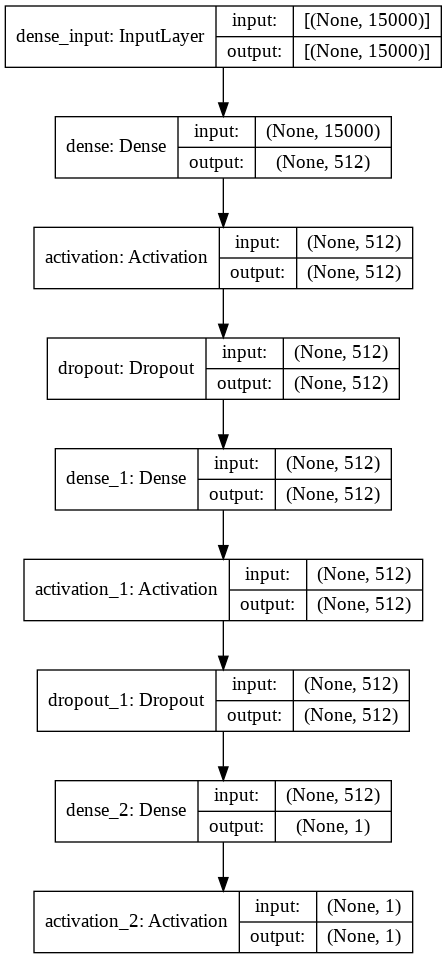

In [32]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Compiling the model

In [33]:
#we use binary crossentropy as a loss function in the compiling of the model, because we want to predict whether the news are 'fake' or 'true'
#and 'Adam' as an optimizer (is more robust)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],)

### Training the Feed Forward Network Model

In [34]:
monitor = 'val_loss'

callbacks = [   
    #stop the training when a monitored quantity has stopped improving
    EarlyStopping(monitor=monitor, patience=7, verbose=1, restore_best_weights=True),
             
    #Reduce learning rate is called when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1)]

In [36]:
#we fit the data to our model
history = model.fit(
    x=X_train_lab.todense(), #features (as dense inputs)
    y=y_train_lab,           #labels
    batch_size=batch_size,   
    epochs=nb_epoch,         
    verbose=2,
    callbacks = callbacks,             
    validation_data=(       
    X_test_lab.todense(),               
    y_test_lab))

Epoch 1/30
385/385 - 7s - loss: 0.1082 - accuracy: 0.9691 - val_loss: 0.0655 - val_accuracy: 0.9814
Epoch 2/30
385/385 - 3s - loss: 0.0273 - accuracy: 0.9934 - val_loss: 0.0936 - val_accuracy: 0.9776
Epoch 3/30
385/385 - 3s - loss: 0.0176 - accuracy: 0.9967 - val_loss: 0.0923 - val_accuracy: 0.9818
Epoch 4/30
385/385 - 3s - loss: 0.0130 - accuracy: 0.9971 - val_loss: 0.2309 - val_accuracy: 0.9725
Epoch 5/30
385/385 - 3s - loss: 0.0226 - accuracy: 0.9969 - val_loss: 0.1147 - val_accuracy: 0.9803
Epoch 6/30
385/385 - 3s - loss: 0.0192 - accuracy: 0.9979 - val_loss: 0.1040 - val_accuracy: 0.9833

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
385/385 - 3s - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.1102 - val_accuracy: 0.9819
Epoch 8/30
385/385 - 3s - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.1106 - val_accuracy: 0.9824
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


In [35]:
def plot_keras_history(history):
    """    
    :param history: 
    :return: 
    """ 
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        if i == 2:
          break
        else:
          #getting the training values
          metric_train_values = history.history.get(metric, [])
          
          #getting the validation values
          metric_val_values = history.history.get("val_{}".format(metric), [])

          epochs = range(1, len(metric_train_values) + 1)
          
          #leaving extra spaces to allign with the validation text
          training_text = "   Training {}: {:.5f}".format(metric,
                                                          metric_train_values[-1])

          #metric
          plt.figure(i, figsize=(12, 6))
          plt.plot(epochs, metric_train_values, 'b', label=training_text)
          
          #if the validation metric exists, then plot that as well
          if metric_val_values:
              validation_text = "Validation {}: {:.5f}".format(metric,
                                                              metric_val_values[-1])

              plt.plot(epochs, metric_val_values, 'g', label=validation_text)
          
          #add title, xlabel, ylabel, and legend
          plt.title('Model Metric: {}'.format(metric))
          plt.xlabel('Epochs')
          plt.ylabel(metric.title())
          plt.legend()

    plt.show()

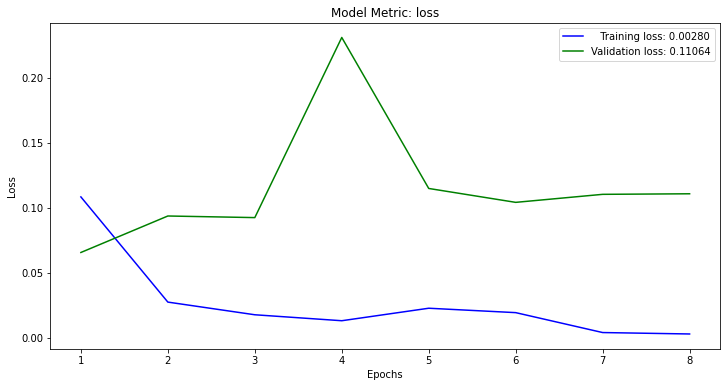

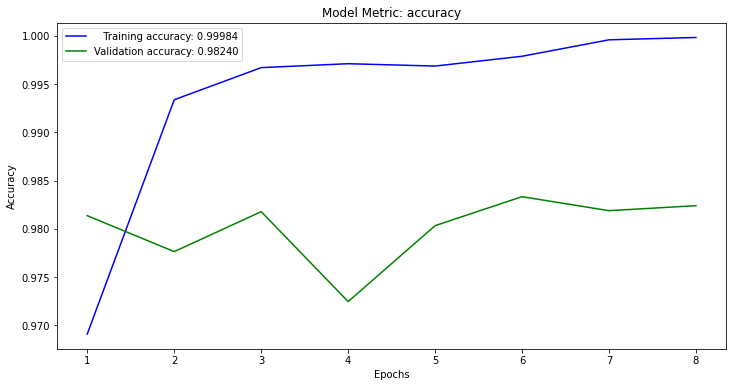

In [37]:
plot_keras_history(history)

### Model Evaluation

In [38]:
#evaluate and store on score variable the test dataset
score = model.evaluate(
    X_val_lab.todense(),    
    y_val_lab,             
    batch_size=batch_size,   
    verbose=2)

68/68 - 0s - loss: 0.0731 - accuracy: 0.9814


In [39]:
print('\nTest binary_crossentropy: {:.4f}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.0731

Test accuracy: 98.137 %


---
In the above plots and after the evaluation of the model, we can see the basic metrics of our Feed Forward Neural Network and how they evolve in the passing of the epochs. 
* First of all, the loss function, a function that shows the error, takes very small values. This is more than good, because it shows that the error for predicting the right class in our binary classification problem is minor. Combining with the fact of both the training and the validation loss have very low values (**from about 0.11 to 0.07**) it is a good indicator of a very promising model. We have to clarify that the training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.

* On the other hand, the accuracy metric, a metric  that depicts the ratio of number of correct predictions to the total number of input samples is really high (**above 98%** for both training and validation accuracy). This means that our model is very accurate and predicts correctly the class of the news (fake or true) nearly all the time.

### Model Prediction 

In [40]:
#get the probabilities for each category for every news
y_val_pred_probs = model.predict(X_val_lab)
y_val_pred_probs

array([[1.3277236e-02],
       [1.0000000e+00],
       [7.0681039e-09],
       ...,
       [3.4091771e-03],
       [2.6385189e-06],
       [7.2719895e-06]], dtype=float32)

In [41]:
y_val_pred_probs.shape

(4347, 1)

In [42]:
#show the class they belong
y_val_preds = (y_val_pred_probs >= 0.5).astype('int64')

y_val_preds[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0]])

* Some more evaluation merics.

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [44]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_val_lab, y_pred=y_val_preds)
pd.DataFrame(conf_mat, columns = y_lab.classes_, index=y_lab.classes_)

,fake,true
fake,1939,24
true,57,2327


* From the above confusion matrix we can observe that the performance of the model is pretty good. This is concluded by the fact that the predicted values do not differ a lot from the actual values. For example, from the 1963 false news, only the 24 predicted falsefully as true and from the 2384 true new only 57 predicted as fake.

In [45]:
#classification report
print(classification_report(y_true=y_val_lab, y_pred=y_val_preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1963
           1       0.99      0.98      0.98      2384

    accuracy                           0.98      4347
   macro avg       0.98      0.98      0.98      4347
weighted avg       0.98      0.98      0.98      4347



Before analyzing the classifiation report it is worth mentioning the definitions of the above metrics. 
* **Precision** : the number of correct positive results divided by the number of positive results predicted by the classifier.
* **Recall** : the number of correct positive results divided by the number of all samples that should have been identified as positive
* **F1 Score**: the Harmonic Mean between precision and recall. It shows how precise our classifier is (how many instances are classified correctly), as well as how robust it is (it does not miss a significant number of instances).
* **Support**: the number of news.

After checking the results of our classification report we can assume that our model performs really good (**from 97% to 99%**).

In [46]:
def plot_binary_class_row_auc(y_true,
                              clf_names: list,
                              clfs_preds: list):
    """

    :param y_true: The true labels in label encoding
    :param clf_names: The names of the classifiers in order to plot
    :param clfs_preds: A list of numpy arrays, that contain predictions from various classifiers
    :return:
    """
    assert len(clf_names) == len(clfs_preds)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)
    plt.plot([0, 1],
             [0, 1],
             'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

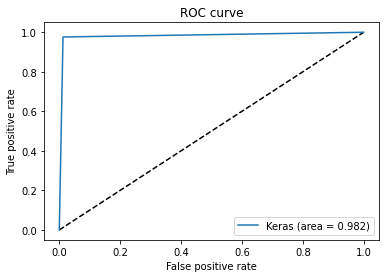

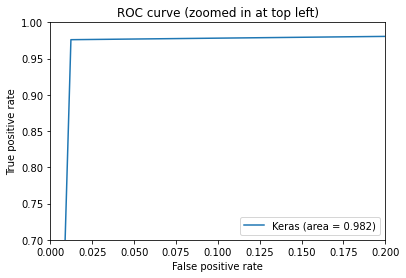

In [47]:
#ROC curve
plot_binary_class_row_auc(y_true=y_val_lab,
                          clf_names=['Keras'],
                          clfs_preds=[y_val_preds.ravel()])

In [48]:
print('ROC Curve Score: ', roc_auc_score(y_val_lab, y_val_preds))

ROC Curve Score:  0.9819322098076154


Area Under Curve (AUC) of a classifier is the probability that a classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. So, we want the curve to approach as much the upper left corner of the graph as possible. In other words we want the ratio true positive to false positive to have the biggest possible value. This is happening to our case, something which indicates nearly perfect performance of our model (98,19%).

* Let 's see an example for testing the accuracy of the model.

In [49]:
df[df['clean_text'] == X_val.iloc[1400,]]

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
27629,Trump warns Republicans against pushing a thir...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,2016-03-21,true,2,"['WASHINGTON', '(Reuters)', 'Republican', 'pre...",[],WASHINGTON - republican presidential front-r...,[],[],trump warns republicans against pushing a thir...,"['WASHINGTON', 'republican', 'presidential', '...","['trump', 'warns', 'republicans', 'against', '..."


In [50]:
X_val.iloc[1400,]

'WASHINGTON   - republican presidential front-runner donald trump on monday warned republicans against backing a third-party candidate should he win the party’s nomination, saying doing so would hand the election to the democrats. “democrats are going to win almost certainly,” trump said at a news conference in commenting on the prospects of republicans trying to coalesce around a third-party candidate to prevent him from winning office. “you can’t be that spiteful because you would destroy the country.”'

In [51]:
input_news = X_val.iloc[1400,]

#vectorizing news with Count Vectorizer
news_vect = counter_vectorizer.transform([input_news])

print(news_vect.shape, end='\n\n')

news_pred = model.predict(news_vect)

print('Probabilities:', end='\n\n')
print(news_pred, end='\n\n')

news_pred_lab = (news_pred >= 0.5).astype('int64')

print('Probabilities Label Vector:', end='\n\n')
print(news_pred_lab, end='\n\n')

print('News Prediction:', end='\n\n')
if news_pred_lab == 0:
  print('fake')
else:
  print('true')

(1, 15000)

Probabilities:

[[0.93805283]]

Probabilities Label Vector:

[[1]]

News Prediction:

true


In [62]:
#save the weights of the model
model.save_weights('feed_forward_label_encoding.h5')

## Word Embeddings

---
An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings are very useful for representing words, because the take into account the semantics of each word. For example, similar inputs are placed close together in the embedding space. 

The major difference with label-encoding is that it turns text into sequence of numbers. 

In [ ]:
import os
from glob import glob
from typing import Tuple, List
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.python.keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from ipywidgets import interact

In [ ]:
max_words = 15_000  #we will only take the 15K most used words in the whole news dataset

#initialize the Keras tokenizer
reviews_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizer.fit_on_texts(X_train)

In [ ]:
reviews_tokenizerTest = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizerTest.fit_on_texts(X_test)

In [ ]:
reviews_tokenizerVal = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
reviews_tokenizerVal.fit_on_texts(X_val)

In [ ]:
xtrain_seq = reviews_tokenizer.texts_to_sequences(X_train)
xtest_seq = reviews_tokenizerTest.texts_to_sequences(X_test)
xval_seq = reviews_tokenizerVal.texts_to_sequences(X_val)

* In order to continue, we have to make sure that all the sentences that will be used in our model will have the same length. So, we use the `Keras pad sequences tool`. This tool, cuts those sentences that are too big and for those that are too small adds zeros. 

Here, we make all the sentences to have length 401 words (the average words of each sentence).

In [ ]:
import statistics
seq_len = [len(i.split()) for i in X_train]
MAX_LENGHT = int(statistics.mean(seq_len))
print(MAX_LENGHT)

401


In [ ]:
xtrain_pad = pad_sequences(xtrain_seq, maxlen=MAX_LENGHT)
xtest_pad = pad_sequences(xtest_seq, maxlen=MAX_LENGHT)
xval_pad = pad_sequences(xval_seq, maxlen=MAX_LENGHT) #create embedding (wonrds into sequence of numbers)

* These tokenizers create a dictionary that maps each word to a number. If we take a closer look, we can infer that those words are used more in the news take a lower token number. Some examples are the following:

In [ ]:
word_index = reviews_tokenizer.word_index

print('Token for the word "news": {}'.format(word_index['news']))
print('Token for the word "the": {}'.format(word_index['the']))
print('Token for the word "happy": {}'.format(word_index['happy']))
print('Token for the word "sad": {}'.format(word_index['sad']))

Token for the word "news": 106
Token for the word "the": 2
Token for the word "happy": 1663
Token for the word "sad": 2258


* Build the vocabulary from the text taken in [Kaggle](https://www.kaggle.com/thanakomsn/glove6b300dtxt?select=glove.6B.300d.txt)

In [ ]:
embedding_vectors = {}
with open('gdrive/MyDrive/glove.6B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}") 

Size of vocabulary in GloVe: 400000


In [ ]:
#initialize the embedding_matrix with zeros
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)

#### Model Setup

In [ ]:
# Setting the model
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_len,
                      output_dim=300,
                      embeddings_initializer='uniform',
                      mask_zero=True, weights=[embedding_matrix],
                      input_length=MAX_LENGHT))

model1.add(Flatten()) #flattening is converting the data into a 1-dimensional array for inputting it to the next layer

model1.add(Dense(512, activation='relu'))

#use a dropout layer with with 40% of inputs dropped
model1.add(Dropout(dropout_rate))

#add a dense layer (MLP) 
model1.add(Dense(1, activation='sigmoid'))

print(model1.summary())

model1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 401, 300)          4500000   
_________________________________________________________________
flatten (Flatten)            (None, 120300)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               61594112  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 66,094,625
Trainable params: 66,094,625
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model1.fit(xtrain_pad, y_train_lab,
                     epochs=30,
                     batch_size=64,
                     callbacks = callbacks,
                     validation_data=(xtest_pad, y_test_lab))

Epoch 1/30
385/385 [==============================] - 313s 812ms/step - loss: 0.2040 - acc: 0.9474 - val_loss: 0.6411 - val_acc: 0.7317
Epoch 2/30
385/385 [==============================] - 310s 807ms/step - loss: 0.0098 - acc: 0.9973 - val_loss: 0.8182 - val_acc: 0.7239
Epoch 3/30
385/385 [==============================] - 310s 806ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 1.2198 - val_acc: 0.7094
Epoch 4/30
385/385 [==============================] - 310s 805ms/step - loss: 4.7362e-04 - acc: 1.0000 - val_loss: 1.1155 - val_acc: 0.7298
Epoch 5/30
385/385 [==============================] - 310s 805ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 1.7344 - val_acc: 0.6975
Epoch 6/30
385/385 [==============================] - 310s 806ms/step - loss: 0.0136 - acc: 0.9957 - val_loss: 1.7578 - val_acc: 0.7093

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
385/385 [==============================] - 310s 805ms/step - loss: 0.0046 - acc: 0.9985

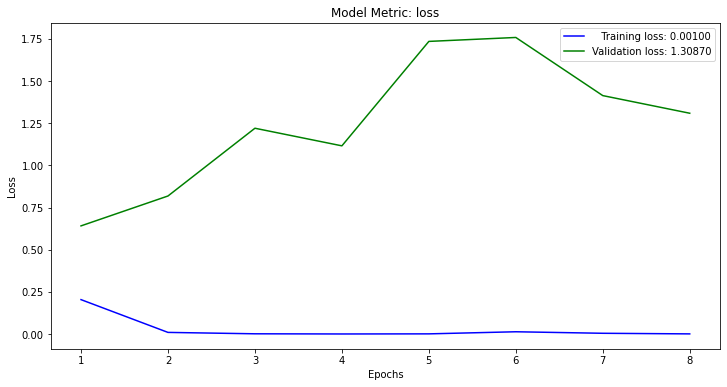

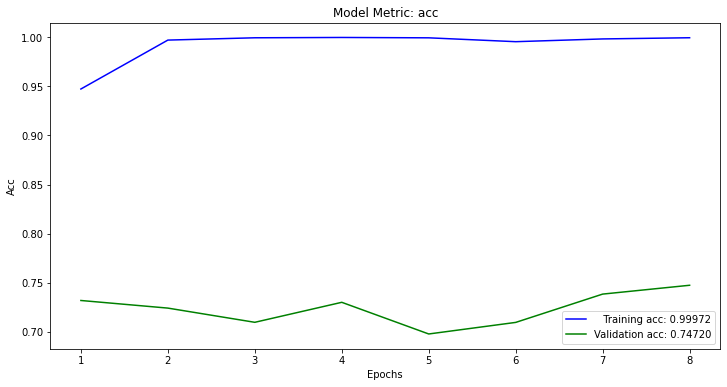

In [ ]:
plot_keras_history(history)

### Predicting using the fitted model

In [ ]:
score = model1.evaluate(
    xval_pad,    
    y_val_lab,             
    batch_size=batch_size,   
    verbose=2)

68/68 - 10s - loss: 0.7003 - acc: 0.7039


In [ ]:
print('\nTest binary_crossentropy: {:.4f}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.7003

Test accuracy: 70.393 %


* In this case we can observe that the model was created with embeddings is worse than the previous one as far as the loss and the accuracy in the training and test set. We can see 1,31 loss on validation set, 0,70 loss on test set, approximately 75 % accuracy on validation set and only 70,4 % accuracy on test set. These differences are pretty big comparing with the previous model, which had very satisfying results. 

In [ ]:
y_val_pred_probs = model1.predict(xval_pad)
y_val_pred_probs

array([[0.2810756 ],
       [0.998646  ],
       [0.39778343],
       ...,
       [0.53716797],
       [0.90908134],
       [0.19215226]], dtype=float32)

In [ ]:
y_val_preds = (y_val_pred_probs >= 0.5).astype('int64')

y_val_preds[:10]

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [ ]:
#confusion matrix
conf_mat = confusion_matrix(y_true=y_val_lab, y_pred=y_val_preds)
pd.DataFrame(conf_mat, columns = y_lab.classes_, index= y_lab.classes_)

,fake,true
fake,932,1031
true,256,2128


In [ ]:
#classification report
print(classification_report(y_true=y_val_lab, y_pred=y_val_preds))

              precision    recall  f1-score   support

           0       0.78      0.47      0.59      1963
           1       0.67      0.89      0.77      2384

    accuracy                           0.70      4347
   macro avg       0.73      0.68      0.68      4347
weighted avg       0.72      0.70      0.69      4347



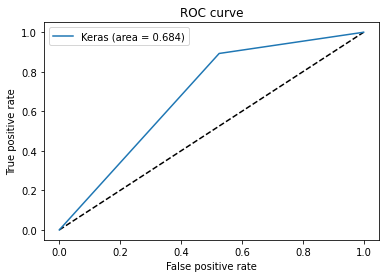

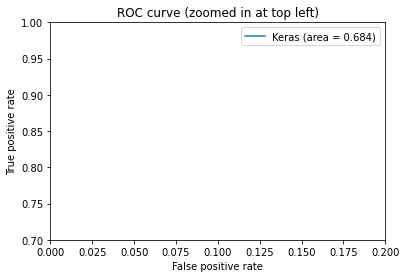

In [ ]:
#ROC curve
plot_binary_class_row_auc(y_true=y_val_lab,
                          clf_names=['Keras'],
                          clfs_preds=[y_val_preds.ravel()])

In [ ]:
print('ROC Curve Score: ', roc_auc_score(y_val_lab, y_val_preds))

ROC Curve Score:  0.6837004721577369


In [ ]:
#save the weights of the model
model1.save_weights('feed_forward_embeddings.h5')

Here is an example. We are giving a text in the model and it returns to us how much fake it is.

In [ ]:
X_val.iloc[1943,]

'OOPS! IN   BILL CLINTON SAID THE SAME THING MAKE AMERICA GREAT AGAIN :'

In [ ]:
df[df['clean_text'] == X_val.iloc[1943,]]

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
12690,IRONIC: WHITE SOUTHERNER BILL CLINTON Just Tol...,OOPS! IN 2008 BILL CLINTON SAID THE SAME THING...,politics,2016-09-09,fake,41,"['OOPS', 'IN', '2008', 'BILL', 'CLINTON', 'SAI...",[],OOPS! IN BILL CLINTON SAID THE SAME THING MA...,[],[],IRONIC: WHITE SOUTHERNER BILL CLINTON just tol...,"['OOPS', '!', 'IN', 'BILL', 'CLINTON', 'SAID',...","['IRONIC', 'WHITE', 'SOUTHERNER', 'BILL', 'CLI..."


In [ ]:
# Demo on a fake text
my_text = df.iloc[12690,1] #the index

seq = reviews_tokenizer.texts_to_sequences([my_text])
print('raw seq:', seq)

seq = pad_sequences(seq, maxlen=MAX_LENGHT)
print('padded seq:', seq)

prediction = model1.predict(seq)
print('truthfullness:', prediction)

raw seq: [[12293, 7, 1, 161, 78, 13, 2, 245, 412, 135, 183, 375, 298]]
padded seq: [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    

---
* From the demo example and from the above evaluation metrics we can draw the following conclusions:

1.   **Binary Crossentropy Loss function**: gives us on validation set 0,70 loss
2.   **Accuracy**: 70.4% on validation set,
3.   **Confusion Matrix**: From the 1963 false news the majority of them (1031) predicted falsefully as true and from the 2384 true news the 256 predicted as fake.
4.    **Classification Report**: As we said before, F1 score, which shows how good our classifier is and its robustness has 59% value on fake and 77% on true news. With combination of the value of the recall (47% and 89% respectively), we can infer that our recurrent NN model fits somehow bad in the data and predicts with medium presicion the fact that one article maybe fake or true as well.
5.    **ROC Curve**: Combined the above plot and its score (68.37%) we can conclude that the ratio of true positive to false positive has medium value.

Although these evaluation metrics were medium, the demo example found the category of the news, where we can see that one random fake news gives a really small number of *'truthfullness'*.